In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms.functional as TF
import random
import torch.nn as nn

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from tqdm import tqdm

from dataset import GTA
from network_swinir import SwinIR

/home/deniz/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
scaling_factor = 2
crop_size = 96*scaling_factor

lr_img_type = '[0, 1]' #'gta-small-norm'
hr_img_type = '[0, 1]'

batch_size = 10
epochs = 2
lr = 1e-4
#grad_clip = None

train_path = 'data/GTAV/small/'
training_data = GTA(train_path,'train',crop_size, scaling_factor,lr_img_type,hr_img_type, same_size_input=False)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_Data = GTA(train_path,'test',crop_size, scaling_factor,lr_img_type,hr_img_type, same_size_input=False)
test_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [5]:
# batch = next(iter(test_dataloader))
# print(len(batch))
# plt.imshow(batch[0][0].permute(1, 2, 0))
# plt.show()
# plt.imshow(batch[1][0].permute(1, 2, 0))
# plt.show()
# print(batch[0][0].shape, batch[1][0].shape)

In [6]:
torch.cuda.empty_cache()

In [7]:
torch.cuda.empty_cache()
upscale = 2
window_size = 8  # Window size remains consistent
height = 96  # Keep input height
width = 96  # Keep input width

# Define a smaller configuration
depths = [4, 4]  # Two stages with fewer blocks per stage
num_heads = [4, 4]  # Fewer attention heads per stage
embed_dim = 48  # Reduced embedding dimension for smaller layers

# Initialize the smaller SwinIR model
model = SwinIR(
    upscale=upscale,
    img_size=(height, width),  # Input image size
    window_size=window_size,  # Window size
    img_range=1.0,  # Image normalization range
    depths=depths,  # Reduced depth
    embed_dim=embed_dim,  # Smaller embedding dimension
    num_heads=num_heads,  # Fewer attention heads
    mlp_ratio=2,  # Default MLP ratio
    upsampler='pixelshuffledirect'  # Lightweight upsampler
).to('cuda')  # Move the model to GPU

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

/home/deniz/.local/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
from torchsummary import summary

summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 96, 96]           1,344
         LayerNorm-2             [-1, 9216, 48]              96
        PatchEmbed-3             [-1, 9216, 48]               0
           Dropout-4             [-1, 9216, 48]               0
         LayerNorm-5             [-1, 9216, 48]              96
            Linear-6              [-1, 64, 144]           7,056
           Softmax-7            [-1, 4, 64, 64]               0
           Dropout-8            [-1, 4, 64, 64]               0
            Linear-9               [-1, 64, 48]           2,352
          Dropout-10               [-1, 64, 48]               0
  WindowAttention-11               [-1, 64, 48]               0
         Identity-12             [-1, 9216, 48]               0
        LayerNorm-13             [-1, 9216, 48]              96
           Linear-14             [-1, 9

In [9]:
losses = []

In [11]:
criterion = nn.MSELoss().to(device)
start_epoch = 0

epochs = 10
for epoch in range(epochs):
    print("EPOCH",epoch+start_epoch+1)
    running_loss = 0
    print_freq = 20
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
    for i,(lr_imgs, hr_imgs) in enumerate(loop):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()

        # # Clip gradients, if necessary
        # if grad_clip is not None:
        #     clip_gradient(optimizer, grad_clip)

        optimizer.step()
        running_loss += loss.item()
        if i % print_freq==print_freq-1:
            current_loss = running_loss / print_freq
            losses.append(current_loss)
            running_loss = 0

            loop.set_postfix(loss=current_loss)
            
    torch.save({'epoch': len(losses),
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_SwinIR.pth.tar')

EPOCH 1


Epoch 1/10: 100%|██████████| 251/251 [03:20<00:00,  1.25it/s, loss=0.00344]


EPOCH 2


Epoch 2/10: 100%|██████████| 251/251 [03:20<00:00,  1.25it/s, loss=0.00172]


EPOCH 3


Epoch 3/10: 100%|██████████| 251/251 [03:20<00:00,  1.25it/s, loss=0.00145]


EPOCH 4


Epoch 4/10: 100%|██████████| 251/251 [03:20<00:00,  1.25it/s, loss=0.00127]


EPOCH 5


Epoch 5/10: 100%|██████████| 251/251 [03:20<00:00,  1.25it/s, loss=0.00103] 


EPOCH 6


Epoch 6/10: 100%|██████████| 251/251 [03:20<00:00,  1.25it/s, loss=0.00111] 


EPOCH 7


Epoch 7/10: 100%|██████████| 251/251 [03:20<00:00,  1.25it/s, loss=0.00094] 


EPOCH 8


Epoch 8/10: 100%|██████████| 251/251 [03:21<00:00,  1.25it/s, loss=0.000779]


EPOCH 9


Epoch 9/10: 100%|██████████| 251/251 [03:21<00:00,  1.25it/s, loss=0.000848]


EPOCH 10


Epoch 10/10: 100%|██████████| 251/251 [03:20<00:00,  1.25it/s, loss=0.000931]


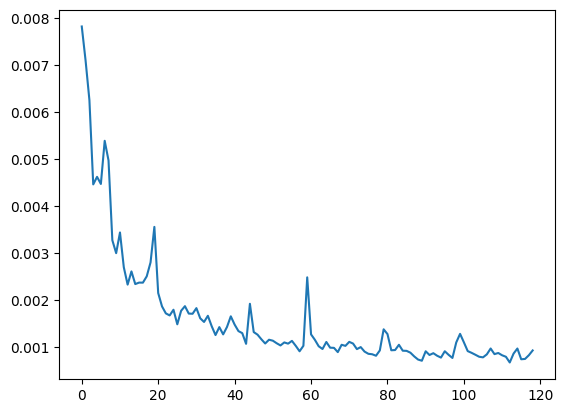

In [19]:
plt.plot(losses[2:])
plt.show()

In [13]:
len(losses)

121

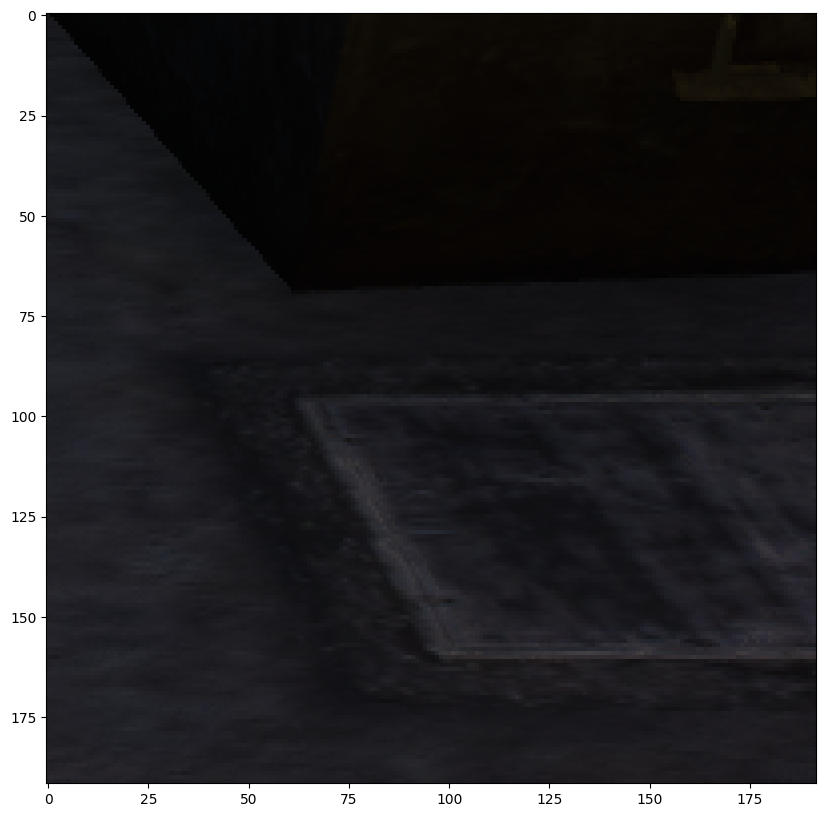

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


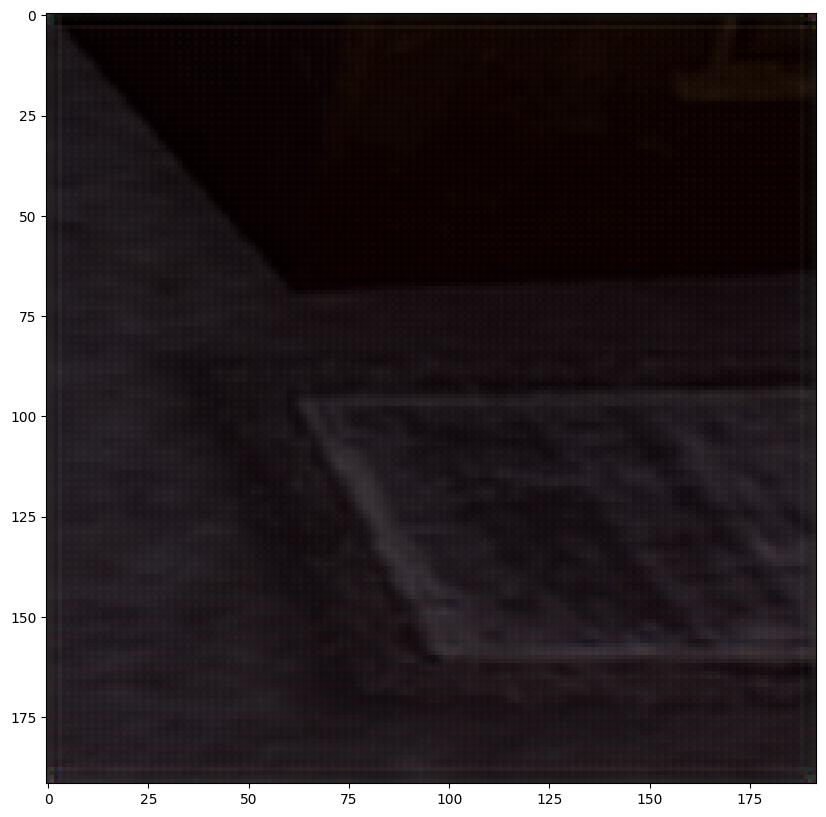

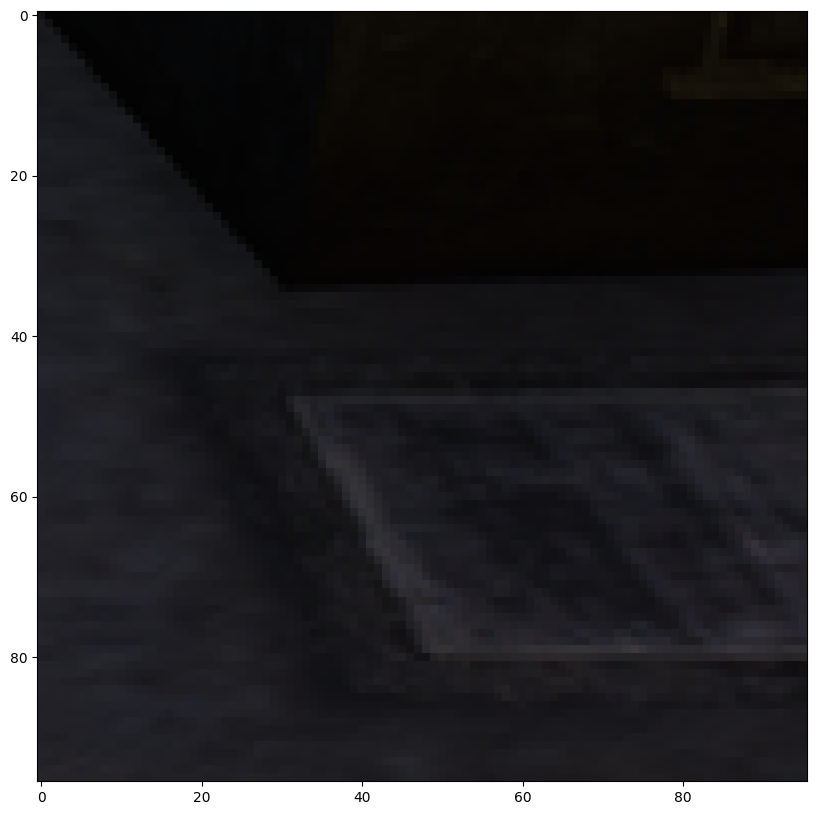

(192, 192, 3) (96, 96, 3) (192, 192, 3)


In [16]:
with torch.no_grad():
    for lr_img, hr_img in training_data:
        model.eval()
        sr_img = model(lr_img.unsqueeze(0).to(device)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
        # plt.imshow(np.concatenate([sr_img, (hr_img).permute(1, 2, 0).numpy()], axis=1))
        # plt.show()
        size = (10,10)
        plt.figure(figsize=size)
        plt.imshow((hr_img).permute(1, 2, 0).numpy())
        plt.show()
        plt.figure(figsize=size)
        plt.imshow(sr_img)
        plt.show()
        plt.figure(figsize=size)
        plt.imshow((lr_img).permute(1, 2, 0).numpy())
        plt.show()
        print(sr_img.shape, (lr_img).permute(1, 2, 0).numpy().shape, (hr_img).permute(1, 2, 0).numpy().shape)
        break

In [17]:
torch.save({'epoch': len(losses),
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_SwinIR.pth.tar')